In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from gensim.models import word2vec
from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import json
import requests
import xgboost as xgb
import itertools
import string
import re
%matplotlib inline

In [54]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RafaelMedeirosJacome\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RafaelMedeirosJacome\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
file='movies_portuguese.csv'
df=pd.read_csv(file, encoding='utf-8')

In [56]:
df.head()

,text,label
0,Recebi bem antes do prazo estipulado.,1
1,Parabéns lojas lannister adorei comprar pela I...,1
2,aparelho eficiente. no site a marca do aparelh...,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
4,"Vendedor confiável, produto ok e entrega antes...",1


In [57]:
df['label'].value_counts()

1    25873
0    14127
Name: label, dtype: int64

In [58]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [59]:
X_train.head()

36862    muito insatisfeita pois eu comprei o produto n...
11768    comprei um tapete com o nome "tapete flash g b...
36393       eu esperava q o produto fosse um pouco melhor.
12031    produto de qualidade original, e entrega dentr...
27211    recebi o produto no prazo e o material de qual...
Name: text, dtype: object

In [60]:
pattern = "[A-Za-zÀ-ÿ]+"
#pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list=stopwords.words('portuguese')
tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [61]:
print(tokenized_train[:20])

36862    [muito, insatisfeita, pois, eu, comprei, o, pr...
11768    [comprei, um, tapete, com, o, nome, tapete, fl...
36393    [eu, esperava, q, o, produto, fosse, um, pouco...
12031    [produto, de, qualidade, original, e, entrega,...
27211    [recebi, o, produto, no, prazo, e, o, material...
23690    [entrega, rápida, antes, da, data, prevista, p...
32052                                                [boa]
14337                      [entrega, rápida, como, sempre]
16003    [produto, conforme, a, imagem, ilustrativa, su...
39921    [demorou, semana, para, gerar, a, nota, e, no,...
17504    [chegou, antes, do, prazo, bem, embalado, e, e...
2468     [ótimo, produto, entrega, rápida, e, super, be...
23264    [produto, de, boa, qualidade, recebi, no, praz...
228                                           [loja, nota]
33826    [abri, a, embalagem, cx, papelão, e, esperava,...
16926    [obs, como, voces, dividiram, fracionaram, o, ...
7979                                    [chegou, quebrad

In [62]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [63]:
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [64]:
tokenized_train.head()

36862    [muito, insatisfeita, pois, eu, comprei, o, pr...
11768    [comprei, um, tapete, com, o, nome, tapete, fl...
36393    [eu, esperava, q, o, produto, fosse, um, pouco...
12031    [produto, de, qualidade, original, e, entrega,...
27211    [recebi, o, produto, no, prazo, e, o, material...
Name: text, dtype: object

In [65]:
ns_tk_train.head()

36862    [insatisfeita, pois, comprei, produto, recebi,...
11768    [comprei, tapete, nome, tapete, flash, g, borr...
36393                [esperava, q, produto, pouco, melhor]
12031    [produto, qualidade, original, entrega, dentro...
27211    [recebi, produto, prazo, material, qualidade, ...
Name: text, dtype: object

In [66]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [67]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [68]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [69]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

13055

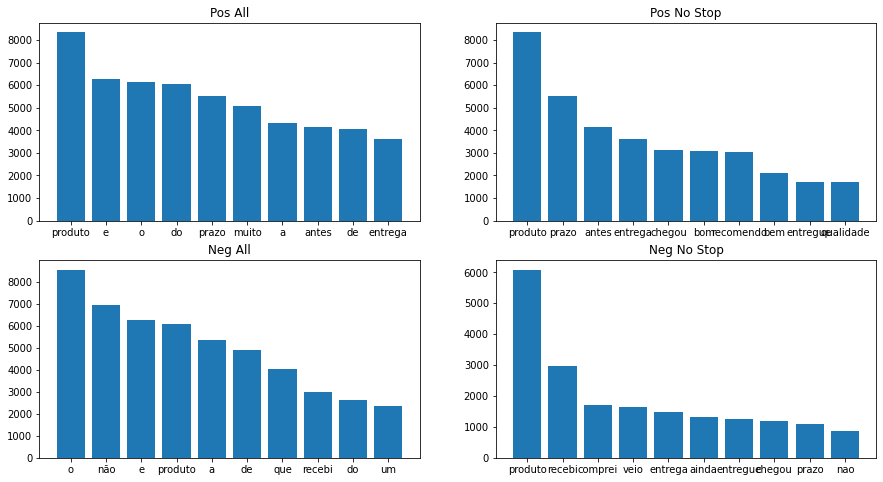

In [70]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])

In [71]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br
18698,"[bom, dia, gostaria, de, saber, porque, meu, p...","[bom, dia, gostaria, saber, porque, pedido, ve...",0,1
32034,"[chego, certo, adoro, comprar, na, lannister, ...","[chego, certo, adoro, comprar, lannister, br, ...",1,1
29086,"[fiz, vários, pedidos, lannister, com, br, ess...","[fiz, vários, pedidos, lannister, br, pedido, ...",0,1
26876,"[há, muito, sou, cliente, de, lannister, com, ...","[cliente, lannister, br, momento, tudo, transc...",1,1
38276,"[rastreamento, pp, br, ainda, não, chegou, na,...","[rastreamento, pp, br, ainda, chegou, unidade,...",0,1


In [72]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

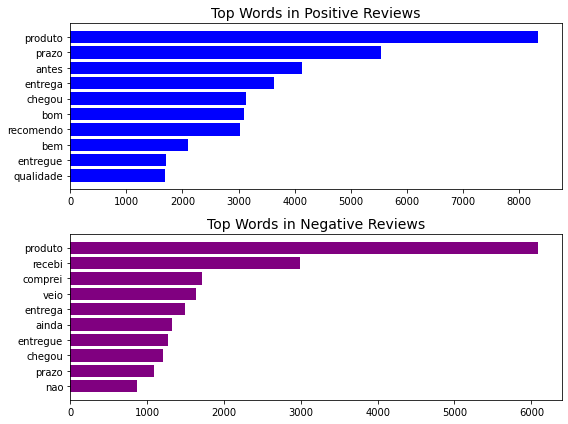

In [73]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(10)
neg_fd=FreqDist(neg['token'].explode()).most_common(10)
pos_fd.sort(key=lambda x: x[1])
neg_fd.sort(key=lambda x: x[1])

fig,axes=plt.subplots(2,figsize=(8,6))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]



axes[0].barh(pos_x,pos_y,color='blue')
axes[0].set_title('Top Words in Positive Reviews',fontsize=14)
axes[1].barh(neg_x,neg_y,color='purple')
axes[1].set_title('Top Words in Negative Reviews',fontsize=14)
plt.tight_layout()

In [84]:
stopwords_list=stopwords.words('portuguese')
stopwords_list.append('br')
#remove=['up','down','didn',"didn't",'wasn',"wasn't",'wouldn',"wouldn't"]
#for word in remove:
#    stopwords_list.remove(word)
    
stemmer=SnowballStemmer('portuguese')
stopwords_stemmed=[]

for w in stopwords_list:
    stopwords_stemmed.append(stemmer.stem(w))
    
wnl=WordNetLemmatizer()
stopwords_lemmatized=[]

for w in stopwords_list:
    stopwords_lemmatized.append(wnl.lemmatize(w))

In [85]:
def correct_spelling(tokens):
    spell=SpellChecker()
    fixed=[spell.correction(t) if len(spell.unknown([t]))>0 else t for t in tokens]
    return fixed

In [86]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [87]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    """
    Dummy class that allows us to modify only the methods that interest us,
    avoiding redudancy.
    """
    def __init__(self):
        return None

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None):
        return self

In [88]:
class Preprocess(DummyTransformer):
    
    def __init__(self,
                 stopwords_list=stopwords_list,
                 stopwords_stemmed=stopwords_stemmed,
                 stopwords_lemmatized=stopwords_lemmatized,
                 vector='count', 
                 stemming=None,
                 spell_check=False,
                n_grams=(1,1),
                max_df=1.0,
                 max_feat=None,
                chi_percent=None,
                y=None):
        #defines how the text will be preprocessed
        
        self.stopwords_list=stopwords_list
        self.stopwords_stemmed=stopwords_stemmed
        self.stopwords_lemmatized=stopwords_lemmatized
        self.vector = vector 
        #can be 'count','tfidf',or 'embedding'
        self.stemming=stemming
        #can be 'None','stem','lemmatize'
        self.spell_check=spell_check
        #True or False
        self.n_grams=n_grams
        #n_gram to pass to tokenizer like (1,1) or (1,2)
        self.max_df=max_df
        #positive float less than or equal to 1.0, to pass to vectorizer
        self.max_features=max_feat
        self.chi_percent=chi_percent
        self.y=y
        #positive integer less than 100, percent features to keep if filtering with chi2
        #None if no filtering
        #self.glove_file_=glove_file
        #None if using count or tfidf, glove file for word embeddings
         
            
    def tokenize(self,text):
        pattern = "[A-Za-zÀ-ÿ]+"
        tokenizer=RegexpTokenizer(pattern)
        tokens=tokenizer.tokenize(text)
        
        if self.spell_check==True:
            tokens=correct_spelling(tokens)
        
        if self.stemming=='lemmatize':
            
            wnl=WordNetLemmatizer()
            
            stems = []
            
            for item in tokens:
                stems.append(wnl.lemmatize(item))
                
        elif self.stemming=='stem':
            stems=[]
            stemmer=SnowballStemmer('portuguese')
            
            for item in tokens:
                stems.append(stemmer.stem(item))
        
        else:
            stems=tokens
        return stems
    
    def filter_words_by_count(self,X,tokenized):
        
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
            
        vectorizer=CountVectorizer(stop_words=sw[idx],
                                   max_df=self.max_df,
                                   min_df=5)
        vectorizer.fit(X)

        #filter out words
        words_to_keep=vectorizer.vocabulary_.keys()
        filtered_data=tokenized.apply(lambda tok: [w for w in tok if w in words_to_keep])

        return filtered_data
    
    def build_glove(self,tokens):
        total_vocab=set([word for review in tokens for word in review])
        glove = {}
        #count=0
        #words=[]
        with open('glove_portuguese_s100.txt', 'rb') as f:
            for line in f:
                parts = line.split()
                word = parts[0].decode('utf-8')
                if word in total_vocab:
                    vector = np.array(parts[1:], dtype=np.float32)
                    glove[word] = vector
                    #count+=1
                    #words.append(word)
        return glove

    def transform(self, X):
        
        #tokenize according to inputs
        sw=[self.stopwords_list,self.stopwords_stemmed,self.stopwords_lemmatized]
        if self.stemming=='None':
            idx=0
        elif self.stemming=='stem':
            idx=1
        else:
            idx=2
        
        if self.vector=='count':
            
            vectorizer=CountVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
        
        elif self.vector=='tfidf':
            
            vectorizer=TfidfVectorizer(stop_words=sw[idx],
                                       max_features=self.max_features,
                                       tokenizer=self.tokenize,
                                       ngram_range=self.n_grams,
                                       min_df=5,
                                       max_df=self.max_df
                                      )
            tokens=vectorizer.fit_transform(X).toarray()
            
        elif self.vector=='embedding':
            tokenized=X.apply(self.tokenize)
            filtered=self.filter_words_by_count(X,tokenized)
            glove=self.build_glove(filtered)
            w2v=W2vVectorizer(glove)
            tokens=w2v.transform(filtered)
            
        if (self.chi_percent != None) and (self.vector != 'embedding'):
            
            selector=SelectPercentile(chi2,percentile=self.chi_percent)
            selected=selector.fit_transform(tokens,self.y)
            tokens=selected
        #print('finished')
        return tokens


In [89]:
def preprocess_grid(X_train,y_train,vector_type,params_lists):
    combos=list(itertools.product(*params_lists))
    print(len(combos))
    tokenized=[]
    count=0
    for c in combos:
        pp=Preprocess(stopwords_list=stopwords_list,
                      vector=vector_type, 
                     stemming=c[0],
                     spell_check=c[1],
                    n_grams=c[2],
                    max_df=c[3],
                    chi_percent=c[4],
                      max_feat=10000,
                    y=y_train)
        tokens=pp.transform(X_train)
        tokenized.append((c,tokens))
        count+=1
        #print(count)
    return tokenized

In [90]:
def pipeline_nlp(estimator,vector_type,X_train,y_train,params_lists):
    #returns results from cross validation
    
    tokenized = preprocess_grid(X_train,y_train,vector_type,params_lists)
    results=[]

    count=0

    for features, xtrain in tokenized:
        result=cross_val_score(estimator,xtrain,y_train,cv=3)
        results.append((features,result.mean()))
        count+=1
        #print(count)
    
    return pd.DataFrame(results)

In [91]:
#Define final pipeline with chosen preprocessing steps and model

#takes in raw movie reviews

pattern = "[A-Za-zÀ-ÿ]+"

final_vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                       max_features=20000,
                                       token_pattern=pattern,
                                       ngram_range=(1,2),
                                       min_df=5,
                                       max_df=.6
                                      )

final_selector = SelectPercentile(chi2,percentile=60)

final_model=LogisticRegression(max_iter=1000,
                               C=5,
                               penalty='l2',
                               solver='saga')

final_pipeline=Pipeline(steps=[
    ('vectorizer',final_vectorizer),
    ('selector',final_selector),
    ('model',final_model)])

In [92]:
cross_val_score(final_pipeline,X_train,y_train)

array([0.88609375, 0.88890625, 0.88828125, 0.88609375, 0.89109375])

In [93]:
final_pipeline.fit(X_train,y_train)

final_pipeline.score(X_test,y_test)

0.88875

In [94]:
y_hat_prob=final_pipeline.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_hat_prob)
print('roc-auc for the final model is: {}'.format(roc_auc))

roc-auc for the final model is: 0.9411011542021583


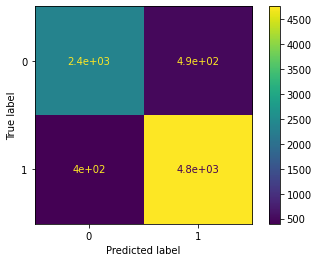

In [95]:
plot_confusion_matrix(final_pipeline,X_test,y_test)

In [96]:
y_hat=final_pipeline.predict(X_test)
classification_report(y_test,y_hat,output_dict=True)

{'0': {'precision': 0.8558427375318529,
  'recall': 0.8263620386643233,
  'f1-score': 0.8408440629470673,
  'support': 2845},
 '1': {'precision': 0.9059584999048163,
  'recall': 0.9231813773035887,
  'f1-score': 0.9144888547271329,
  'support': 5155},
 'accuracy': 0.88875,
 'macro avg': {'precision': 0.8809006187183346,
  'recall': 0.8747717079839561,
  'f1-score': 0.8776664588371001,
  'support': 8000},
 'weighted avg': {'precision': 0.8881360819109311,
  'recall': 0.88875,
  'f1-score': 0.8882989256503471,
  'support': 8000}}

In [97]:
logreg_coef=final_pipeline.get_params()['model'].coef_[0]

In [98]:
len(logreg_coef)

4395

In [99]:
logreg_coef

array([-2.05926075, -0.83368114,  0.73711209, ..., -0.62518158,
       -1.05971863, -1.89959305])

In [100]:
tfidf_mapping=final_pipeline.get_params()['vectorizer'].vocabulary_

In [101]:
tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_map[:10]

[('insatisfeita', 3478),
 ('pois', 4749),
 ('comprei', 1396),
 ('produto', 5221),
 ('recebi', 5839),
 ('nenhuma', 4163),
 ('posição', 4839),
 ('devo', 2039),
 ('proceder', 5207),
 ('obter', 4267)]

In [102]:
tfidf_map.sort(key=lambda x: x[1])

In [103]:
tfidf_map[:5]

[('abaixo', 0), ('abajur', 1), ('abençoe', 2), ('aberta', 3), ('aberto', 4)]

In [104]:
vocab_tfidf=[x[0] for x in tfidf_map]
vocab_tfidf[:10]

['abaixo',
 'abajur',
 'abençoe',
 'aberta',
 'aberto',
 'abraço',
 'abraços',
 'abri',
 'abri caixa',
 'abri chamado']

In [105]:
fitted_sel=final_pipeline.get_params()['selector']
fitted_sel

SelectPercentile(percentile=60,
                 score_func=<function chi2 at 0x000001DD0014D0D8>)

In [106]:
mask=fitted_sel.get_support()

In [107]:
mask

array([False, False, False, ..., False, False, False])

In [108]:
final_vocab=np.array(vocab_tfidf)[mask]

In [109]:
len(final_vocab)

4395

In [110]:
coef_df=pd.DataFrame(list(zip(final_vocab,logreg_coef)),columns=['word','coef'])
coef_df.head()

,word,coef
0,aberta,-2.059261
1,aberto,-0.833681
2,abraços,0.737112
3,abri,1.331324
4,abri chamado,-1.202490


In [111]:
coef_df.sort_values(by='coef',ascending=False).head()

,word,coef
2602,parabéns,6.512440
52,adorei,5.818150
1652,excelente,5.695199
2736,perfeito,5.504220
205,antes,5.430639


In [112]:
word_dict_negative = {}
word_dict_positive = {}
for row in coef_df.sort_values(by='coef',ascending=False).iterrows():
    if(row[1]['coef'] >= 0):
        word_dict_positive[row[1]['word']] = row[1]['coef']
    else:
        word_dict_negative[row[1]['word']] = -1 * row[1]['coef']

In [113]:
#positives from logistic regression

In [114]:
from statistics import mean 
from sklearn import preprocessing
import numpy as np

word_dict_positive_values_list = np.array(list(word_dict_positive.values()))

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(word_dict_positive_values_list.reshape(-1, 1))

In [115]:
i = 0
word_dict_positive_scaled = {}
for key in word_dict_positive.keys():
    key_splitted_values = key.split()
    if(len(key_splitted_values) > 1):
        for key_splitted in key_splitted_values:
            if (key_splitted not in word_dict_positive_scaled.keys()):
                word_dict_positive_scaled[key_splitted] = values_scaled[i][0]
    else:
        word_dict_positive_scaled[key] = values_scaled[i][0]
    i = i + 1

In [116]:
word_dict_positive_final = dict(sorted(word_dict_positive_scaled.items(), key=lambda item: item[1]))

In [117]:
print(len(word_dict_positive_final))

742


In [118]:
# negatives from logistic regression

In [119]:
from statistics import mean 
from sklearn import preprocessing
import numpy as np

word_dict_negative_scaled = {}

word_dict_negative_values_list = np.array(list(word_dict_negative.values()))

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(word_dict_negative_values_list.reshape(-1, 1))

In [120]:
i = 0
for key in word_dict_negative.keys():
    key_splitted_values = key.split()
    if(len(key_splitted_values) > 1):
        for key_splitted in key_splitted_values:
            if (key_splitted not in word_dict_negative_scaled.keys()): 
                word_dict_negative_scaled[key_splitted] = values_scaled[i][0]
    else:
        word_dict_negative_scaled[key] = values_scaled[i][0]
    i = i + 1

In [121]:
word_dict_negative_final = dict(sorted(word_dict_negative_scaled.items(), key=lambda item: item[1]))

In [122]:
print(len(word_dict_negative_final))

1514
